# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.33KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

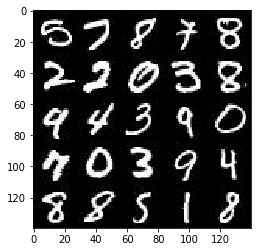

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

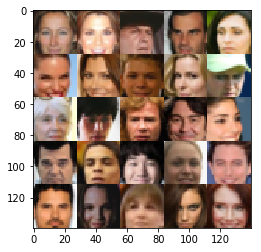

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # First fully connected layer
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha*x1, x1)
        # Now 2*2*512

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # Now 4*4*256

        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # Now 8*8*128
        
        x4 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x4, training = is_train)
        x3 = tf.maximum(alpha*x4, x4)

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='same')

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(d_logits_real) * (1 - smooth), logits = d_logits_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(d_logits_fake), logits = d_logits_fake))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(d_logits_fake), logits = d_logits_fake))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    b, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.6412... Generator Loss: 0.0621
Epoch 1/2... Discriminator Loss: 1.5027... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 2.3472... Generator Loss: 1.9294
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.5818
Epoch 1/2... Discriminator Loss: 1.5084... Generator Loss: 1.5204
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.8331
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 1.3207
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 1.4320
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 1.2949


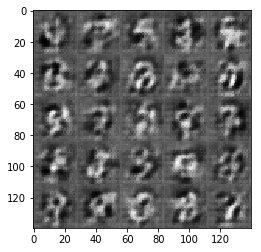

Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.1740
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 1.2188
Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 1.4238
Epoch 1/2... Discriminator Loss: 1.0421... Generator Loss: 1.4734
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 2.4147
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 0.9373
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 1.2013


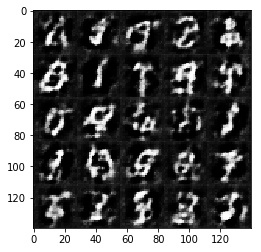

Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.6044... Generator Loss: 0.4118
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 1.3873
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 1.2239
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 1.6892
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.6175


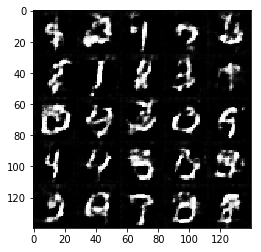

Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 1.7696
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 1.0578
Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 1.3514
Epoch 1/2... Discriminator Loss: 0.9995... Generator Loss: 0.9085
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 1.5018
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 1.1757
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 1.2748... Generator Loss: 1.0602
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.5361


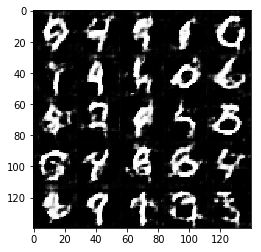

Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 1.3605
Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.5192
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 2.2406
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 1.3923
Epoch 1/2... Discriminator Loss: 1.7621... Generator Loss: 0.3505
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.7999


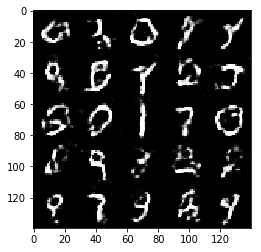

Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.3753
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 1.0003... Generator Loss: 0.9572
Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 1.1243
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 2.0531
Epoch 1/2... Discriminator Loss: 0.8904... Generator Loss: 1.3260
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 1.1545


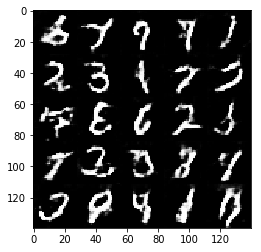

Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 0.8487
Epoch 1/2... Discriminator Loss: 2.7683... Generator Loss: 0.1753
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 1.3038
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.5606
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 1.3847
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 0.9907... Generator Loss: 1.0991
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 0.7748


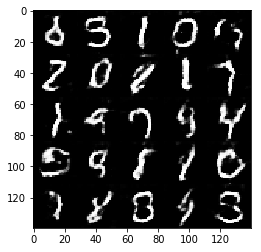

Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 1.6123
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.2742
Epoch 1/2... Discriminator Loss: 2.1292... Generator Loss: 2.9682
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 1.1278
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 1.9729


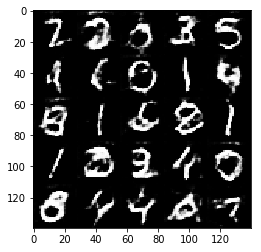

Epoch 1/2... Discriminator Loss: 1.9119... Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 0.9771
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.5528
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.6350
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 2.0320
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 1.1880
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 0.8485... Generator Loss: 1.4617
Epoch 1/2... Discriminator Loss: 1.5966... Generator Loss: 0.4171


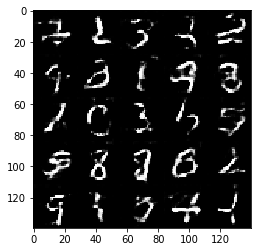

Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 1.7017
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 1.7699
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.3065
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 1.6939
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 2.7594... Generator Loss: 4.3928
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 0.8240


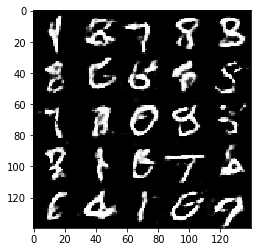

Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.9722
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 1.6125... Generator Loss: 0.4596
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 0.8139
Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 1.3358
Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 0.9352
Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 0.9146
Epoch 2/2... Discriminator Loss: 1.9833... Generator Loss: 0.3305
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.0131


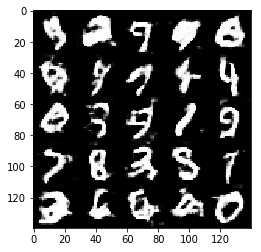

Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 0.8469... Generator Loss: 1.1877
Epoch 2/2... Discriminator Loss: 0.9005... Generator Loss: 1.1044
Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 1.2526
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 1.5643... Generator Loss: 2.8537
Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.5460
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.3509
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.1775


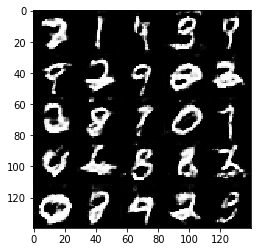

Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 1.2508
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.2541
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 1.9221
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 1.0850
Epoch 2/2... Discriminator Loss: 0.7338... Generator Loss: 1.3508
Epoch 2/2... Discriminator Loss: 0.6455... Generator Loss: 1.5876
Epoch 2/2... Discriminator Loss: 0.7195... Generator Loss: 1.2922


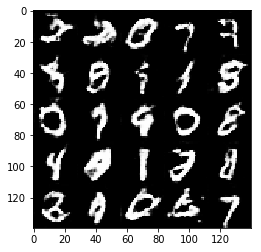

Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.7490
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 1.1931
Epoch 2/2... Discriminator Loss: 0.9703... Generator Loss: 0.9211
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 1.1840
Epoch 2/2... Discriminator Loss: 0.6543... Generator Loss: 1.5443
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.0750
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 0.6045... Generator Loss: 1.9380
Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 1.4410


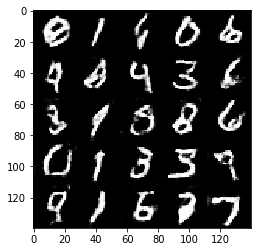

Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 1.5377
Epoch 2/2... Discriminator Loss: 1.6986... Generator Loss: 0.3833
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.4229
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.7212
Epoch 2/2... Discriminator Loss: 2.0147... Generator Loss: 4.2711
Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 1.0427
Epoch 2/2... Discriminator Loss: 0.7029... Generator Loss: 1.8723


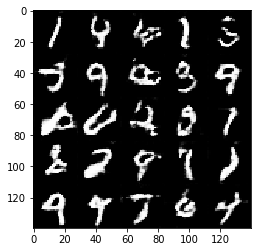

Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 1.4990
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 1.6716
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 1.7921
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 2.0829
Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 1.2522
Epoch 2/2... Discriminator Loss: 0.6540... Generator Loss: 1.5667
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 1.7503
Epoch 2/2... Discriminator Loss: 2.6325... Generator Loss: 0.2211
Epoch 2/2... Discriminator Loss: 0.9068... Generator Loss: 1.3595


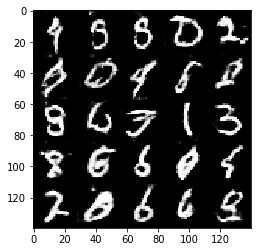

Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.9207
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 1.5903
Epoch 2/2... Discriminator Loss: 0.6342... Generator Loss: 1.5227
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 0.7753
Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 1.6693
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 3.0041
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.2107
Epoch 2/2... Discriminator Loss: 0.5987... Generator Loss: 2.2208


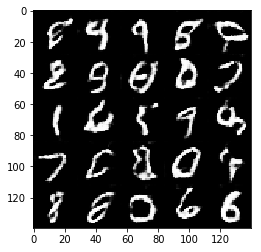

Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.7719
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.3094
Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 1.4696
Epoch 2/2... Discriminator Loss: 0.5672... Generator Loss: 2.1926
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.9565
Epoch 2/2... Discriminator Loss: 0.9702... Generator Loss: 3.0115
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.7910
Epoch 2/2... Discriminator Loss: 0.6530... Generator Loss: 1.5188
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.3035


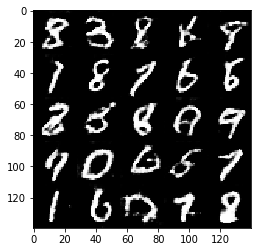

Epoch 2/2... Discriminator Loss: 0.5414... Generator Loss: 2.0023
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 0.6723... Generator Loss: 1.6622
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 0.5653... Generator Loss: 1.8578
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 0.6180... Generator Loss: 1.7557


In [41]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 2.7355
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 3.0453
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.7322... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.7663... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.0104


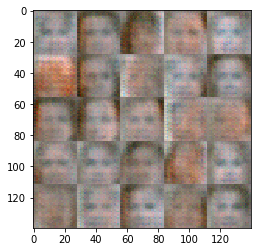

Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 1.9341
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 0.4180


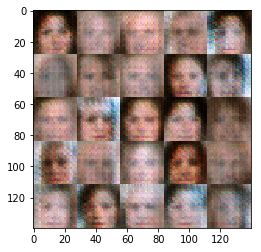

Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.8253... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6704


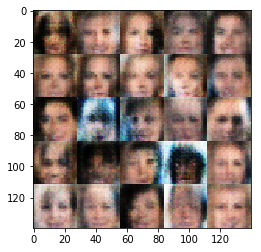

Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.6427... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.9337


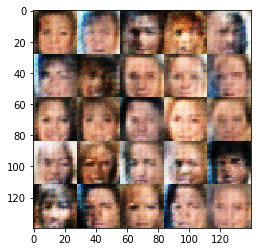

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6884


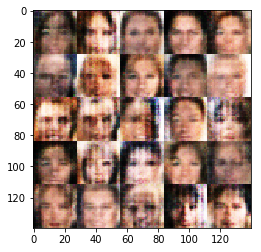

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.5637


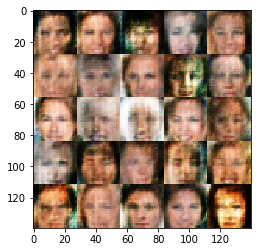

Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7294


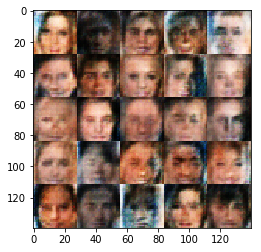

Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.9014


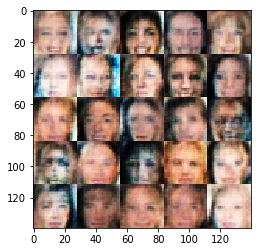

Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.9038


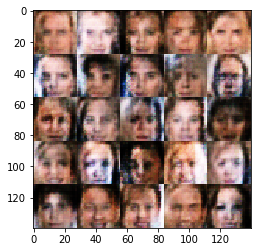

Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7804


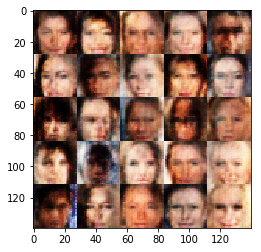

Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.9255


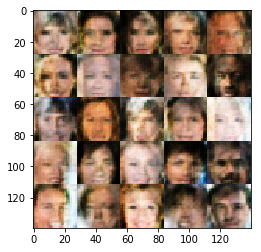

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.9048


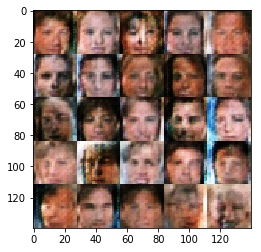

Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 1.4237
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7110


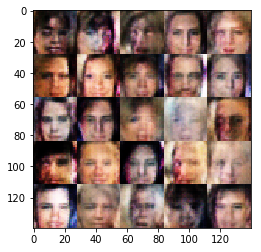

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.7500


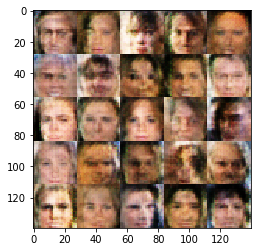

Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.9765


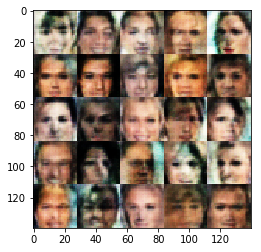

Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.2542
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6095


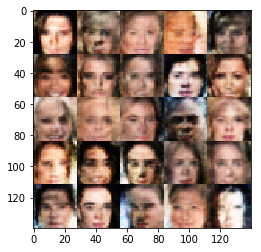

Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.8381


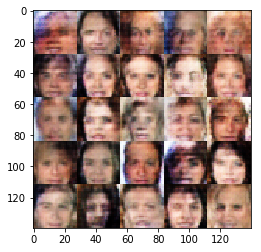

Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.8810


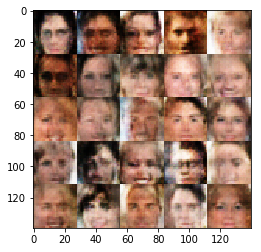

Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6952


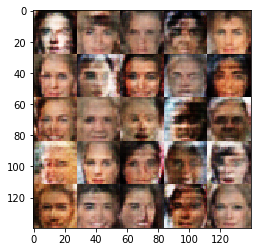

Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6610


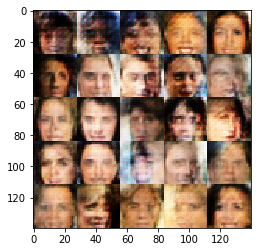

Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.8366


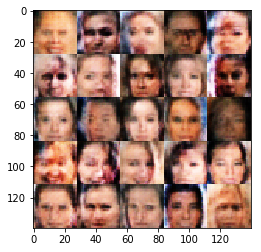

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5638


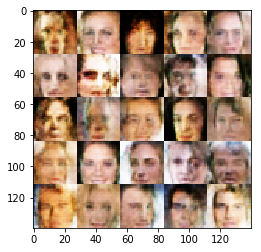

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5298


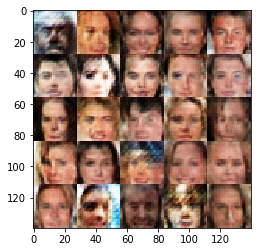

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.6798... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8652


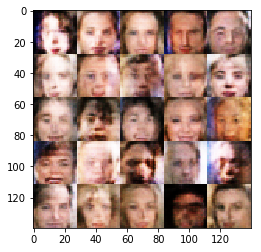

Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.8571


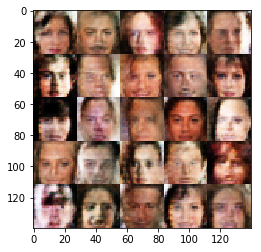

Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.1225


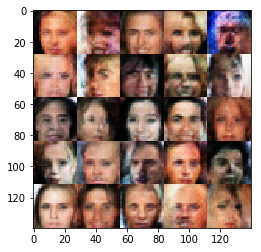

Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.0289


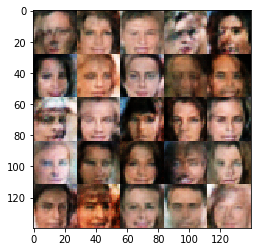

Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.4116


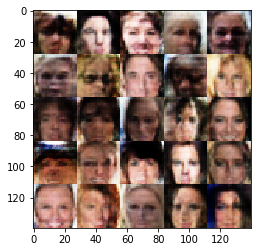

Epoch 1/1... Discriminator Loss: 1.6666... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.4744


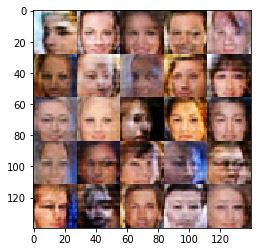

Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 1.3888
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.5341


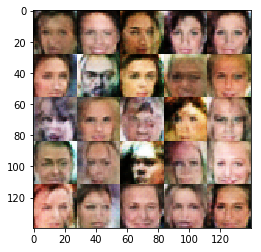

Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 1.7118
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.9155


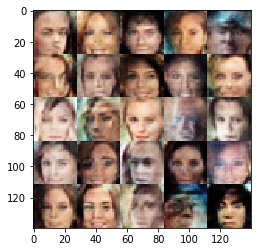

Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.9980


In [42]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.